In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# change path
import os

project_fname = '/content/drive/My Drive/EEG_Dataset/'
os.chdir(project_fname)
project_data_path = os.path.join(project_fname,'project_data/')
print(os.getcwd())

In [14]:
import numpy as np
import random
from load_data import * 
from data_preprocessing import * 
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn import preprocessing

X_test, y_test, person_train_valid, X_train_valid, y_train_valid, person_test = load_data(dir_path = project_data_path)

N_trials,N_eeg,N_bins,_ = X_train_valid.shape
X_train_valid_norm = np.reshape(preprocessing.scale(np.reshape(X_train_valid,(N_trials*N_eeg,N_bins)),axis=1),(N_trials,N_eeg,N_bins,1))
N_trials,N_eeg,N_bins,_ = X_test.shape
X_test_norm = np.reshape(preprocessing.scale(np.reshape(X_test,(N_trials*N_eeg,N_bins)),axis=1),(N_trials,N_eeg,N_bins,1))


print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))

Training/Valid data shape: (2115, 22, 1000, 1)
Test data shape: (443, 22, 1000, 1)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


In [15]:
# DATA PREPROCESSING 

subsample = 5
subj = 5
task = 0 
X_train_valid_subsample, y_train_valid_subsample, person_train_valid_subsample = subsample_data(X_train_valid_norm,y_train_valid, person_train_valid, sample_every=subsample)
X_train, y_train, person_train = split_data_by_subject(X_train_valid_subsample, y_train_valid_subsample, person_train_valid_subsample)
X_train,y_train, person_train = split_data_by_task(X_train[subj],y_train[subj], person_train[subj])
X_train,y_train,person_train = X_train[task],y_train[task],person_train[task]
print('Shapes: x = {}, y = {}, person = {}'.format(X_train.shape, y_train.shape, person_train.shape))

# ONLY USE 5 EEG CHANNELS: 0 (Fz), 7 (C3), 9 (Cz), 11 (C4), 19 (Pz)
X_train = X_train[:,(0,7,9,11,19),:,:]

# wavelet transform 
N_trials,N_eeg,N_bins,_ = X_train.shape
fs = 250
freq_bins = 50
X_train_cwt = morlet_wavelet_transform(X_train,fs=fs,freq_range=(1,20),freq_bins=freq_bins,w=6)
# reshape for DCGAN 
X_train_cwt = np.swapaxes(np.swapaxes(X_train_cwt,1,3),1,2)
# scale between -1 and 1 for output of Generator
X_train_cwt_norm = 2 * (X_train_cwt - np.min(X_train_cwt,axis=0) ) / (np.max(X_train_cwt,axis=0) - np.min(X_train_cwt,axis=0)) - 1


print('X_cwt_norm = {}'.format(X_train_cwt_norm.shape))

(2115, 22, 200, 1)
(2115, 22, 200, 1)
(2115, 22, 200, 1)
(2115, 22, 200, 1)
(2115, 22, 200, 1)
Shapes: x = (285, 22, 200, 1), y = (285,), person = (285,)
Performing discrete CWT convolutions...



X_cwt_norm = (285, 50, 200, 5)


CWT, eeg 0, person 5.0, task 0, trial 100


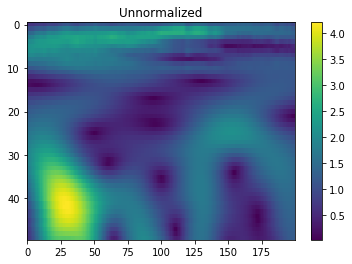

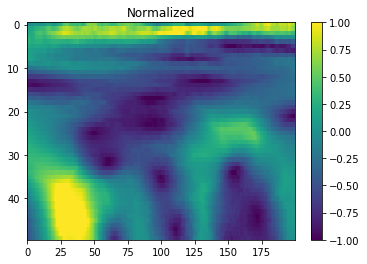

In [16]:
# DISPLAY EXAMPLES 
trial = 100
eeg = 0

# print('CWT, eeg {}, person {}, task {}, trial {}'.format(eeg,subj,task,trial))
print('CWT, eeg {}, person {}, task {}, trial {}'.format(eeg,person_train[trial],task,trial))
plt.figure(1)
plt.title('Unnormalized')
plt.imshow(X_train_cwt[trial,:,:,eeg],aspect='auto')
plt.colorbar()

plt.figure(2)
plt.title('Normalized')
plt.imshow(X_train_cwt_norm[trial,:,:,eeg],aspect='auto')
plt.colorbar()

In [8]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

TensorFlow 2.x selected.
Tensorflow version 2.1.0
Running on TPU  ['10.70.92.106:8470']
INFO:tensorflow:Initializing the TPU system: 10.70.92.106:8470


INFO:tensorflow:Initializing the TPU system: 10.70.92.106:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [ ]:
## WGAN
from tensorflow.keras import layers
from tensorflow.keras.losses import binary_crossentropy
import tensorflow.keras.backend as K 
from functools import partial
from tqdm import tqdm
from IPython.display import clear_output 
import time

class WGANGP(): 
  def __init__(self, noise_dim=100,dropout=0.2):   
    # setup config variables eg. noise_dim, hyperparams, verbose, plotting etc. 
    self.noise_dim = noise_dim
    self.dropout = dropout
    self.eeg_img_shape = (50,200,5)
        
    # setup history dictionary
    self.history = {}

    # build discriminator and generator models
    self.generator = self.build_generator()
    self.discriminator = self.build_discriminator()

  def build_generator(self):
    model = tf.keras.Sequential()
    model.add(layers.Dense(4*11*512, use_bias=False, input_shape=(self.noise_dim,)))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Reshape((4, 11, 512)))
    assert model.output_shape == (None, 4, 11, 512) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(256, (5, 4), strides=(2, 2), padding='valid', use_bias=False))
    assert model.output_shape == (None, 11, 24, 256)
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(128, (5, 4), strides=(2, 2), padding='valid', use_bias=False))
    assert model.output_shape == (None, 25, 50, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 50, 100, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(5, (5, 5), strides=(1, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 50, 200, 5)

    return model

  def build_discriminator(self):
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=self.eeg_img_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    #model.add(layers.Dropout(self.dropout))
    assert model.output_shape == (None,25,100,64) 

    model.add(layers.Conv2D(128, (5, 5), strides=(1, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(self.dropout)) # output = (25, 50, 128)
    assert model.output_shape == (None,25,50,128) 

    model.add(layers.Flatten())
    model.add(layers.Dropout(self.dropout))
    model.add(layers.Dense(1))
    assert model.output_shape == (None,1) 
    
    return model
  
  # generate fake data after training! 
  def generate_fake_data(self,N=100): 
    noise = tf.random.normal([N, self.noise_dim]).numpy()
    return generator(noise, training=False).numpy(), noise 
    
  # loss functions
  def disc_loss(self, fake_logits, real_logits):
    return tf.reduce_mean(fake_logits) - tf.reduce_mean(real_logits)

  def gen_loss(self,fake_logits): 
    return - tf.reduce_mean(fake_logits)
  
  # gradient penalty term for discriminator 
  def gradient_penalty(self, discriminator, real_imgs, gen_imgs): 
    eps = tf.random.uniform([real_imgs.shape[0], 1, 1, 1], 0., 1.)
    inter = real_imgs + (eps * (real_imgs - gen_imgs))
    with tf.GradientTape() as tape: 
      tape.watch(inter)
      pred = discriminator(inter)
    
    grad = tape.gradient(pred,inter)[0]
    grad_l2_norm = tf.sqrt(tf.reduce_sum(tf.square(grad)))
    
    return tf.reduce_mean(grad_l2_norm) 
  
  @tf.function
  def train_step(self,images):
    
    # loss variables to return
    disc_loss, disc_grads = 0,0
    
    # ---------------------
    #  Train Discriminator
    # ---------------------

    # train discriminator over several iterations 
    for _ in range(self.discriminator_iters):
      # setup gradient tools -- GradientTape automatically watches all trainable variables 
      with tf.GradientTape() as disc_tape:
        # forward prop
        noise = tf.random.normal([images.shape[0], self.noise_dim]) 
        gen_imgs = self.generator(noise, training=True)
        fake_logits = self.discriminator(gen_imgs, training=True)
        real_logits = self.discriminator(images, training=True)
        
        # calculate loss
        loss = self.disc_loss(fake_logits,real_logits)
        gp = self.gradient_penalty(partial(self.discriminator, training=True), images, gen_imgs)
        loss += self.gp_weight * gp 

      # back prop      
      disc_grads = disc_tape.gradient(loss, self.discriminator.trainable_variables)
      self.discriminator_optimizer.apply_gradients(zip(disc_grads,self.discriminator.trainable_variables))
      
      # save some variables for history 
      disc_loss += loss
      disc_grads += disc_grads

    # ---------------------
    #  Train Generator 
    # ---------------------
    noise = tf.random.normal([images.shape[0], self.noise_dim])
    with tf.GradientTape() as gen_tape:
      gen_imgs = self.generator(noise, training=True)
      fake_logits = self.discriminator(gen_imgs, training=True)
      gen_loss = self.gen_loss(fake_logits)

    gen_grads = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
    self.generator_optimizer.apply_gradients(zip(gen_grads, self.generator.trainable_variables))

    return disc_loss, disc_grads[0], gen_loss, gen_grads[0]

  # training loop
  def train(self, train_dataset, generator_optimizer, discriminator_optimizer, 
            epochs=25, batch_size=128, discriminator_iters=5,
            gp_weight=0, plot=False, save_plots=False):
    '''
    Training loop
    INPUTS: 
    dataset - EEG training dataset as numpy array with shape=(trials,eeg,freq_bins,time_bins)
    '''

    # set up data for training
    dataset = tf.data.Dataset.from_tensor_slices(train_dataset.astype('float32')).shuffle(train_dataset.shape[0]).batch(batch_size)
    N_batch = np.ceil(train_dataset.shape[0]/float(batch_size))

    # save optimizers
    self.generator_optimizer = generator_optimizer
    self.discriminator_optimizer = discriminator_optimizer

    # save training variables 
    self.discriminator_iters = discriminator_iters
    self.gp_weight = gp_weight

    # setup history variables 
    history = self.history
    history['grads'], history['loss']= {}, {}
    gen_loss_history, disc_loss_history = [],[]
    gen_grads_history, disc_grads_history= [],[]
    
    # start training loop
    for epoch in range(epochs):
      start = time.time()
      
      # refresh loss for every epoch 
      gen_loss, disc_loss, disc_grads, gen_grads = 0, 0, 0, 0
     
      with tqdm(total=N_batch, position=0, leave=True) as pbar:
        for image_batch in dataset:

          # train step           
          disc_loss_batch, disc_grads_batch, gen_loss_batch, gen_grads_batch = self.train_step(image_batch)   
          
          # convert variables to usable format
          disc_loss_batch = tf.reduce_mean(disc_loss_batch).numpy()/float(self.discriminator_iters)
          disc_grads_batch = tf.reduce_mean(tf.sqrt(tf.reduce_sum(tf.square(disc_grads_batch)))).numpy()/float(self.discriminator_iters)
          gen_loss_batch = tf.reduce_mean(gen_loss_batch).numpy()
          gen_grads_batch = tf.reduce_mean(tf.sqrt(tf.reduce_sum(tf.square(gen_grads_batch)))).numpy()
          
          # store history 
          gen_loss += gen_loss_batch/float(N_batch)
          disc_loss += disc_loss_batch/float(N_batch)
          gen_grads += gen_grads_batch/float(N_batch)
          disc_grads += disc_grads_batch/float(N_batch)

          pbar.update()
      pbar.close()
      
      # store history 
      gen_loss_history.append(gen_loss)
      disc_loss_history.append(disc_loss)
      gen_grads_history.append(gen_grads)
      disc_grads_history.append(disc_grads) 
      

      print ('Epoch #: {}/{}, Time taken: {} secs,\n Grads: disc= {}, gen= {},\n Losses: disc= {}, gen= {}'\
             .format(epoch+1,epochs,time.time()-start, disc_grads, gen_grads, disc_loss, gen_loss))

      if plot and epoch % 20 == 0: 
        # fake image example
        generated_image, _ = self.generate_fake_data(N=1)       
        # real image example  
        trial_ind, eeg = 0, 0
        real_image = np.expand_dims(train_dataset[trial_ind], axis=0)
        
        # visualize fake and real data examples
        plt.figure()
        plt.subplot(121)
        plt.imshow(generated_image[0, :, :, eeg], aspect='auto')
        plt.colorbar()
        plt.title('Fake decision, eeg {}:\n {}'.format(eeg, self.discriminator(generated_image).numpy()))
        plt.subplot(122)
        plt.imshow(real_image[0,:,:,eeg], aspect='auto')
        plt.title('Real decision, trial {}, eeg {}:\n {}'.format(trial_ind, eeg, self.discriminator(real_image).numpy()))
        plt.colorbar()
        plt.subplots_adjust(hspace=0.5)
        plt.show()

        # plot discriminator classification
        gen_imgs, _ = self.generate_fake_data(N=train_dataset.shape[0])
        fake_predictions = self.discriminator(gen_imgs)
        real_predictions = self.discriminator(train_dataset)
        plt.figure()
        plt.plot(real_predictions.numpy(),'bo')
        plt.plot(fake_predictions.numpy(),'ro')
        plt.legend(['Real', 'Fake'])
        plt.show()

    # Generate after the final epoch
    clear_output(wait=True)
    
    plt.figure()
    plt.plot(gen_loss_history, 'r')
    plt.plot(disc_loss_history, 'b')
    plt.title('Loss history')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['Generator', 'Discriminator'])
    plt.show()

    plt.figure()
    plt.plot(gen_grads_history, 'r')
    plt.plot(disc_grads_history, 'b')
    plt.title('Gradient history')
    plt.xlabel('Epochs')
    plt.ylabel('Gradients (L2 norm)')
    plt.legend(['Generator', 'Discriminator'])
    plt.show()

    history['grads']['gen'], history['grads']['disc'] = gen_grads_history, disc_grads_history
    history['loss']['gen'], history['loss']['disc'] = gen_loss_history, disc_loss_history   
    
    self.history = history
    
    return history    

tf.Tensor([[-0.00078369]], shape=(1, 1), dtype=float32)


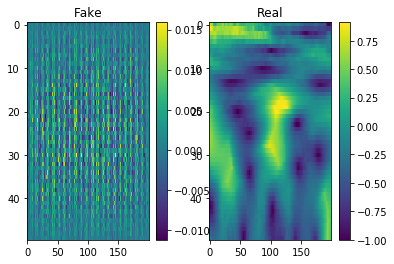

In [10]:

wgan = WGANGP(noise_dim=100, dropout=0.3)

generator = wgan.generator

generated_image, _ = wgan.generate_fake_data(N=1)

plt.subplot(121)
plt.imshow(generated_image[0, :, :, 0], aspect='auto')
plt.title('Fake')
plt.colorbar()
plt.subplot(122)
plt.imshow(X_train_cwt_norm[0,:,:,0], aspect='auto')
plt.title('Real')
plt.colorbar()

discriminator = wgan.discriminator

print (wgan.discriminator(generated_image))


Starting training for task 0


100%|██████████| 3/3.0 [00:34<00:00, 13.34s/it]

Epoch #: 1/200, Time taken: 34.53111004829407 secs,
 Grads: disc= 41.44414367675782, gen= 103.82554499308269,
 Losses: disc= -387.14466145833336, gen= 538.0458577473958

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.





If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



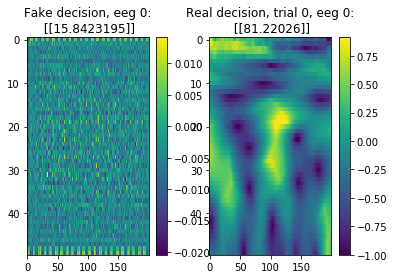

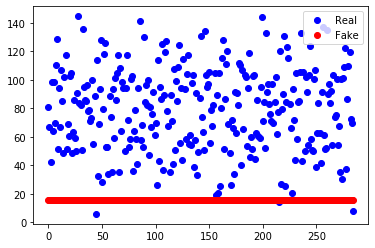

100%|██████████| 3/3.0 [00:15<00:00,  5.12s/it]
  0%|          | 0/3.0 [00:00<?, ?it/s]

Epoch #: 2/200, Time taken: 15.240560293197632 secs,
 Grads: disc= 286.7741333007813, gen= 193.05930074055988,
 Losses: disc= -815.3444010416667, gen= 845.6757609049479


100%|██████████| 3/3.0 [00:15<00:00,  5.10s/it]
  0%|          | 0/3.0 [00:00<?, ?it/s]

Epoch #: 3/200, Time taken: 15.219916820526123 secs,
 Grads: disc= 723.9162434895834, gen= 238.99700927734375,
 Losses: disc= -1387.25625, gen= 1193.925048828125


100%|██████████| 3/3.0 [00:15<00:00,  5.26s/it]
  0%|          | 0/3.0 [00:00<?, ?it/s]

Epoch #: 4/200, Time taken: 15.74898886680603 secs,
 Grads: disc= 1152.1853515625, gen= 303.3260192871094,
 Losses: disc= -1721.462890625, gen= 1430.8206380208335


100%|██████████| 3/3.0 [00:15<00:00,  5.11s/it]
  0%|          | 0/3.0 [00:00<?, ?it/s]

Epoch #: 5/200, Time taken: 15.223036527633667 secs,
 Grads: disc= 1718.2262044270833, gen= 322.6598409016927,
 Losses: disc= -2255.60546875, gen= 1766.3850504557292


100%|██████████| 3/3.0 [00:15<00:00,  5.09s/it]
  0%|          | 0/3.0 [00:00<?, ?it/s]

Epoch #: 6/200, Time taken: 15.175493717193604 secs,
 Grads: disc= 1816.4276692708333, gen= 325.0610758463542,
 Losses: disc= -2837.4810546874996, gen= 2068.788981119792


100%|██████████| 3/3.0 [00:15<00:00,  5.10s/it]
  0%|          | 0/3.0 [00:00<?, ?it/s]

Epoch #: 7/200, Time taken: 15.217997550964355 secs,
 Grads: disc= 2554.499544270833, gen= 343.1123046875,
 Losses: disc= -3051.0379557291667, gen= 2271.478841145833


100%|██████████| 3/3.0 [00:15<00:00,  5.09s/it]
  0%|          | 0/3.0 [00:00<?, ?it/s]

Epoch #: 8/200, Time taken: 15.19135570526123 secs,
 Grads: disc= 2537.2710937499996, gen= 315.29506429036456,
 Losses: disc= -3752.346354166667, gen= 2696.572835286458


100%|██████████| 3/3.0 [00:15<00:00,  5.13s/it]
  0%|          | 0/3.0 [00:00<?, ?it/s]

Epoch #: 9/200, Time taken: 15.323328733444214 secs,
 Grads: disc= 3791.451041666667, gen= 337.2597859700521,
 Losses: disc= -4100.612369791666, gen= 2975.83837890625


100%|██████████| 3/3.0 [00:15<00:00,  5.11s/it]
  0%|          | 0/3.0 [00:00<?, ?it/s]

Epoch #: 10/200, Time taken: 15.267332077026367 secs,
 Grads: disc= 4918.783072916667, gen= 317.51328531901044,
 Losses: disc= -4834.293619791666, gen= 3383.893798828125


100%|██████████| 3/3.0 [00:15<00:00,  5.09s/it]
  0%|          | 0/3.0 [00:00<?, ?it/s]

Epoch #: 11/200, Time taken: 15.23150634765625 secs,
 Grads: disc= 5403.879296875, gen= 310.41123453776044,
 Losses: disc= -5306.748046875, gen= 3707.9619140625


100%|██████████| 3/3.0 [00:15<00:00,  5.18s/it]
  0%|          | 0/3.0 [00:00<?, ?it/s]

Epoch #: 12/200, Time taken: 15.443000555038452 secs,
 Grads: disc= 5612.049869791666, gen= 324.6065266927083,
 Losses: disc= -5930.301953125, gen= 4032.132731119791


100%|██████████| 3/3.0 [00:15<00:00,  5.15s/it]
  0%|          | 0/3.0 [00:00<?, ?it/s]

Epoch #: 13/200, Time taken: 15.3279709815979 secs,
 Grads: disc= 5904.073437499999, gen= 359.3311564127604,
 Losses: disc= -6254.01015625, gen= 4138.679850260416


100%|██████████| 3/3.0 [00:15<00:00,  5.12s/it]
  0%|          | 0/3.0 [00:00<?, ?it/s]

Epoch #: 14/200, Time taken: 15.254762172698975 secs,
 Grads: disc= 7434.1625, gen= 398.85577392578125,
 Losses: disc= -6257.42265625, gen= 4101.074951171875


100%|██████████| 3/3.0 [00:15<00:00,  5.12s/it]
  0%|          | 0/3.0 [00:00<?, ?it/s]

Epoch #: 15/200, Time taken: 15.252203702926636 secs,
 Grads: disc= 6309.100520833333, gen= 399.77452596028644,
 Losses: disc= -7031.89453125, gen= 4401.18408203125


100%|██████████| 3/3.0 [00:15<00:00,  5.10s/it]
  0%|          | 0/3.0 [00:00<?, ?it/s]

Epoch #: 16/200, Time taken: 15.184579610824585 secs,
 Grads: disc= 9386.074479166666, gen= 424.02165730794275,
 Losses: disc= -6699.801041666667, gen= 4158.97802734375


100%|██████████| 3/3.0 [00:15<00:00,  5.10s/it]
  0%|          | 0/3.0 [00:00<?, ?it/s]

Epoch #: 17/200, Time taken: 15.234224557876587 secs,
 Grads: disc= 8554.275260416667, gen= 351.50166829427087,
 Losses: disc= -6780.973697916666, gen= 3988.438313802083


100%|██████████| 3/3.0 [00:15<00:00,  5.13s/it]
  0%|          | 0/3.0 [00:00<?, ?it/s]

Epoch #: 18/200, Time taken: 15.300978899002075 secs,
 Grads: disc= 9757.632291666667, gen= 305.5882263183594,
 Losses: disc= -8461.497135416666, gen= 5136.71875


100%|██████████| 3/3.0 [00:15<00:00,  5.15s/it]
  0%|          | 0/3.0 [00:00<?, ?it/s]

Epoch #: 19/200, Time taken: 15.320465803146362 secs,
 Grads: disc= 9714.105729166666, gen= 327.53057861328125,
 Losses: disc= -9888.409895833332, gen= 5985.052571614583


100%|██████████| 3/3.0 [00:15<00:00,  5.11s/it]
  0%|          | 0/3.0 [00:00<?, ?it/s]

Epoch #: 20/200, Time taken: 15.2419753074646 secs,
 Grads: disc= 13399.021354166667, gen= 388.1272989908854,
 Losses: disc= -10124.73515625, gen= 6272.712890625


100%|██████████| 3/3.0 [00:15<00:00,  5.13s/it]


Epoch #: 21/200, Time taken: 15.333478689193726 secs,
 Grads: disc= 13513.112239583334, gen= 535.2506510416666,
 Losses: disc= -10710.398177083334, gen= 6532.12451171875


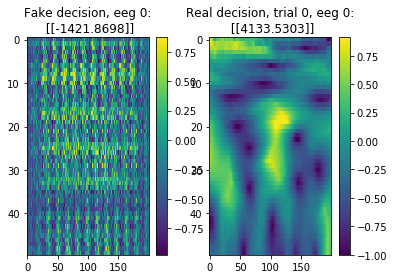

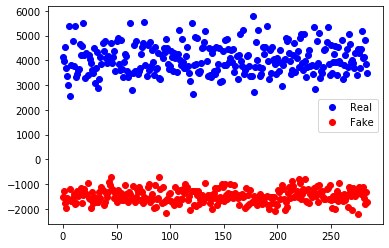

100%|██████████| 3/3.0 [00:15<00:00,  5.20s/it]
  0%|          | 0/3.0 [00:00<?, ?it/s]

Epoch #: 22/200, Time taken: 15.44457197189331 secs,
 Grads: disc= 14030.783593749999, gen= 767.3388671875,
 Losses: disc= -10502.65390625, gen= 6227.382649739584


100%|██████████| 3/3.0 [00:15<00:00,  5.13s/it]
  0%|          | 0/3.0 [00:00<?, ?it/s]

Epoch #: 23/200, Time taken: 15.34349250793457 secs,
 Grads: disc= 11934.031510416666, gen= 938.0315551757812,
 Losses: disc= -9794.645833333332, gen= 5786.871256510416


100%|██████████| 3/3.0 [00:15<00:00,  5.09s/it]
  0%|          | 0/3.0 [00:00<?, ?it/s]

Epoch #: 24/200, Time taken: 15.189098834991455 secs,
 Grads: disc= 19059.78958333333, gen= 1226.2032063802085,
 Losses: disc= -8658.8421875, gen= 4841.312662760417


100%|██████████| 3/3.0 [00:15<00:00,  5.14s/it]
  0%|          | 0/3.0 [00:00<?, ?it/s]

Epoch #: 25/200, Time taken: 15.31801176071167 secs,
 Grads: disc= 11544.355729166668, gen= 1309.8209635416667,
 Losses: disc= -8127.9375, gen= 4973.97705078125


100%|██████████| 3/3.0 [00:15<00:00,  5.09s/it]
  0%|          | 0/3.0 [00:00<?, ?it/s]

Epoch #: 26/200, Time taken: 15.230760097503662 secs,
 Grads: disc= 24983.255729166667, gen= 1324.5166422526042,
 Losses: disc= -8108.393750000001, gen= 3534.57275390625


100%|██████████| 3/3.0 [00:15<00:00,  5.08s/it]
  0%|          | 0/3.0 [00:00<?, ?it/s]

Epoch #: 27/200, Time taken: 15.133774042129517 secs,
 Grads: disc= 22169.559895833336, gen= 1109.1172892252603,
 Losses: disc= -7877.770052083333, gen= 4002.678548177084


100%|██████████| 3/3.0 [00:15<00:00,  5.15s/it]
  0%|          | 0/3.0 [00:00<?, ?it/s]

Epoch #: 28/200, Time taken: 15.325074911117554 secs,
 Grads: disc= 21095.5203125, gen= 1127.2345581054688,
 Losses: disc= -8271.310416666667, gen= 3003.6874186197915


100%|██████████| 3/3.0 [00:15<00:00,  5.09s/it]
  0%|          | 0/3.0 [00:00<?, ?it/s]

Epoch #: 29/200, Time taken: 15.202297687530518 secs,
 Grads: disc= 22884.4765625, gen= 1042.5637410481772,
 Losses: disc= -9149.3234375, gen= 4416.383626302083


100%|██████████| 3/3.0 [00:15<00:00,  5.14s/it]
  0%|          | 0/3.0 [00:00<?, ?it/s]

Epoch #: 30/200, Time taken: 15.345046997070312 secs,
 Grads: disc= 17695.020572916666, gen= 903.697489420573,
 Losses: disc= -9825.494270833333, gen= 5778.423177083334


100%|██████████| 3/3.0 [00:15<00:00,  5.13s/it]
  0%|          | 0/3.0 [00:00<?, ?it/s]

Epoch #: 31/200, Time taken: 15.298095941543579 secs,
 Grads: disc= 20735.853124999998, gen= 1094.8986002604167,
 Losses: disc= -10852.369010416667, gen= 5353.421875


100%|██████████| 3/3.0 [00:15<00:00,  5.14s/it]
  0%|          | 0/3.0 [00:00<?, ?it/s]

Epoch #: 32/200, Time taken: 15.320139408111572 secs,
 Grads: disc= 18560.568489583333, gen= 1029.656514485677,
 Losses: disc= -11979.770312499999, gen= 5900.414550781249


100%|██████████| 3/3.0 [00:15<00:00,  5.14s/it]
  0%|          | 0/3.0 [00:00<?, ?it/s]

Epoch #: 33/200, Time taken: 15.34562635421753 secs,
 Grads: disc= 21483.929166666665, gen= 863.7373657226562,
 Losses: disc= -12338.626302083334, gen= 6205.760416666666


100%|██████████| 3/3.0 [00:15<00:00,  5.08s/it]
  0%|          | 0/3.0 [00:00<?, ?it/s]

Epoch #: 34/200, Time taken: 15.153443813323975 secs,
 Grads: disc= 19491.1015625, gen= 935.4410400390625,
 Losses: disc= -13308.06875, gen= 6192.919108072916


100%|██████████| 3/3.0 [00:15<00:00,  5.15s/it]
  0%|          | 0/3.0 [00:00<?, ?it/s]

Epoch #: 35/200, Time taken: 15.336378574371338 secs,
 Grads: disc= 24223.57708333333, gen= 1075.444051106771,
 Losses: disc= -13588.87135416667, gen= 6325.731119791667


100%|██████████| 3/3.0 [00:15<00:00,  5.10s/it]
  0%|          | 0/3.0 [00:00<?, ?it/s]

Epoch #: 36/200, Time taken: 15.20106315612793 secs,
 Grads: disc= 23987.079166666666, gen= 929.1034138997397,
 Losses: disc= -14241.90989583333, gen= 6663.436686197917


100%|██████████| 3/3.0 [00:15<00:00,  5.11s/it]
  0%|          | 0/3.0 [00:00<?, ?it/s]

Epoch #: 37/200, Time taken: 15.231212139129639 secs,
 Grads: disc= 20227.9484375, gen= 922.9131876627605,
 Losses: disc= -14774.006249999999, gen= 8231.319661458334


100%|██████████| 3/3.0 [00:15<00:00,  5.13s/it]
  0%|          | 0/3.0 [00:00<?, ?it/s]

Epoch #: 38/200, Time taken: 15.32719612121582 secs,
 Grads: disc= 21456.855729166666, gen= 999.1962076822917,
 Losses: disc= -15561.209375, gen= 7743.45703125


100%|██████████| 3/3.0 [00:15<00:00,  5.12s/it]
  0%|          | 0/3.0 [00:00<?, ?it/s]

Epoch #: 39/200, Time taken: 15.301378726959229 secs,
 Grads: disc= 20685.748958333337, gen= 959.7519938151042,
 Losses: disc= -16342.1671875, gen= 8717.445475260416


100%|██████████| 3/3.0 [00:15<00:00,  5.10s/it]
  0%|          | 0/3.0 [00:00<?, ?it/s]

Epoch #: 40/200, Time taken: 15.224696159362793 secs,
 Grads: disc= 21949.034375, gen= 981.2694091796875,
 Losses: disc= -16309.796874999998, gen= 8658.800455729168


100%|██████████| 3/3.0 [00:15<00:00,  5.13s/it]


Epoch #: 41/200, Time taken: 15.28625774383545 secs,
 Grads: disc= 20468.9484375, gen= 1001.441162109375,
 Losses: disc= -16563.140625, gen= 9271.7958984375


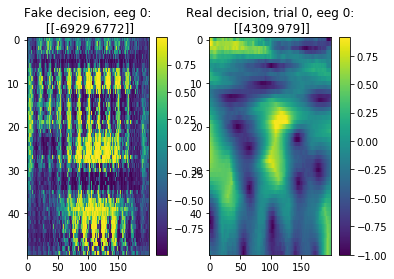

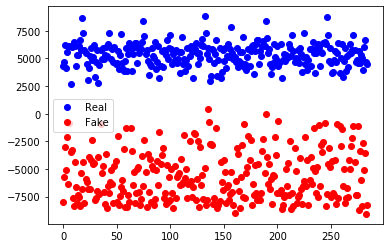

100%|██████████| 3/3.0 [00:15<00:00,  5.12s/it]
  0%|          | 0/3.0 [00:00<?, ?it/s]

Epoch #: 42/200, Time taken: 15.253080129623413 secs,
 Grads: disc= 25023.335416666665, gen= 1143.5660400390625,
 Losses: disc= -16614.706770833334, gen= 8891.528971354166


100%|██████████| 3/3.0 [00:15<00:00,  5.14s/it]
  0%|          | 0/3.0 [00:00<?, ?it/s]

Epoch #: 43/200, Time taken: 15.340686321258545 secs,
 Grads: disc= 33899.660416666666, gen= 1208.1966756184895,
 Losses: disc= -17401.1609375, gen= 7559.250325520834


100%|██████████| 3/3.0 [00:15<00:00,  5.10s/it]
  0%|          | 0/3.0 [00:00<?, ?it/s]

Epoch #: 44/200, Time taken: 15.2213613986969 secs,
 Grads: disc= 29253.598958333332, gen= 1171.5677897135415,
 Losses: disc= -17324.06302083333, gen= 8754.273763020832


100%|██████████| 3/3.0 [00:15<00:00,  5.15s/it]
  0%|          | 0/3.0 [00:00<?, ?it/s]

Epoch #: 45/200, Time taken: 15.356062412261963 secs,
 Grads: disc= 25155.877083333336, gen= 1146.6511027018228,
 Losses: disc= -18448.519270833334, gen= 9747.306640625


100%|██████████| 3/3.0 [00:15<00:00,  5.13s/it]
  0%|          | 0/3.0 [00:00<?, ?it/s]

Epoch #: 46/200, Time taken: 15.326443195343018 secs,
 Grads: disc= 33190.45625, gen= 1162.9490966796875,
 Losses: disc= -19146.1953125, gen= 9394.041341145832


100%|██████████| 3/3.0 [00:15<00:00,  5.16s/it]
  0%|          | 0/3.0 [00:00<?, ?it/s]

Epoch #: 47/200, Time taken: 15.352404594421387 secs,
 Grads: disc= 22654.9140625, gen= 1241.5265299479165,
 Losses: disc= -18897.8375, gen= 9521.806315104166


100%|██████████| 3/3.0 [00:15<00:00,  5.13s/it]
  0%|          | 0/3.0 [00:00<?, ?it/s]

Epoch #: 48/200, Time taken: 15.285625219345093 secs,
 Grads: disc= 23363.24947916667, gen= 1178.5655924479167,
 Losses: disc= -18261.1640625, gen= 8553.875813802084


100%|██████████| 3/3.0 [00:15<00:00,  5.10s/it]
  0%|          | 0/3.0 [00:00<?, ?it/s]

Epoch #: 49/200, Time taken: 15.230557680130005 secs,
 Grads: disc= 23678.596354166668, gen= 1202.3863932291665,
 Losses: disc= -17802.114583333332, gen= 8780.632486979168


 67%|██████▋   | 2/3.0 [00:10<00:05,  5.36s/it]


KeyboardInterrupt: ignored

In [11]:
import numpy as np
import random
from load_data import * 
from data_preprocessing import * 
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn import preprocessing
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras import backend as K
import pickle

# clear backend 
try:
  del wgan
  K.clear_session()
except:
  pass

# init useful params
# decisions, loss_histories = [], []

# setup optimzers
gen_optim = Adam(1e-4, beta_1=0.5)
disc_optim = RMSprop(5e-4)

# setup model 
wgan = WGANGP(noise_dim=100, dropout=0.3)

generator = wgan.generator
discriminator = wgan.discriminator

# Training
print ('Starting training for task {}'.format(task))  
history = wgan.train(X_train_cwt_norm, gen_optim, disc_optim, 
            epochs=300, batch_size=100, discriminator_iters=5,
            gp_weight=10, plot=True)

# compare real and fake EEG data
eeg = 0 
# fake image example
generated_image, _ = wgan.generate_fake_data(N=1)       
# real image example
trial_ind = random.randint(0,X_train_cwt_norm.shape[0])
real_image = np.expand_dims(X_train_cwt_norm[trial_ind],axis=0)

# plotting
plt.figure()
plt.subplot(121)
plt.imshow(generated_image[0, :, :, eeg], aspect='auto')
plt.colorbar()
plt.title('Fake decision, eeg {}:\n {}'.format(eeg, wgan.discriminator(generated_image).numpy()))
plt.subplot(122)
plt.imshow(real_image[0,:,:,eeg], aspect='auto')
plt.title('Real decision, trial {}, eeg {}:\n {}'.format(trial_ind,eeg,wgan.discriminator(real_image).numpy()))
plt.colorbar()
plt.subplots_adjust(hspace=0.5)
plt.show()

# SAVE IMPORTANT THINGS
checkpoint_dir = 'model_checkpoints/ckpt-WGANGP-CWT/'
checkpoint_prefix = os.path.join(project_fname, checkpoint_dir)

# save generator and discriminator weights
time_rn = (datetime.strftime(datetime.now(),"%H_%M_%S_%d_%m_%Y"))
generator_fname = os.path.join(checkpoint_prefix,'generator_5eeg_person{}_task{}_{}.h5'.format(subj,task,time_rn))
print('Saving generator weights to {}'.format(generator_fname))
generator.save(generator_fname)
discriminator_fname = os.path.join(checkpoint_prefix,'discriminator_5eeg_person{}_task{}_{}.h5'.format(subj,task,time_rn))
print('Saving discriminator weights to {}'.format(discriminator_fname))
discriminator.save(discriminator_fname)

# save model performance history 
fname = os.path.join(checkpoint_prefix,'history_5eeg_person{}_task{}_{}'.format(subj,task,time_rn))
fileid = open(fname, 'ab') 
pickle.dump(history, fileid)
fileid.close()

(2115, 22, 200, 1)
(2115, 22, 200, 1)
(2115, 22, 200, 1)
(2115, 22, 200, 1)
(2115, 22, 200, 1)
Performing discrete CWT convolutions...


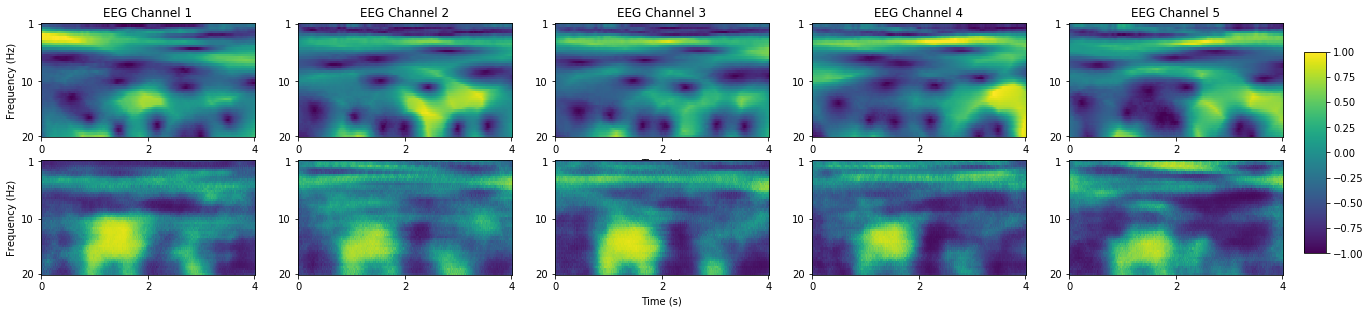

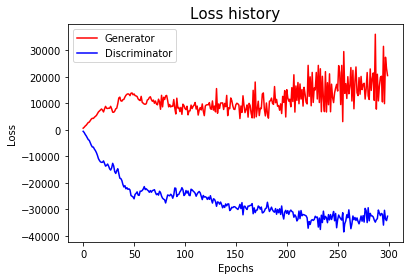

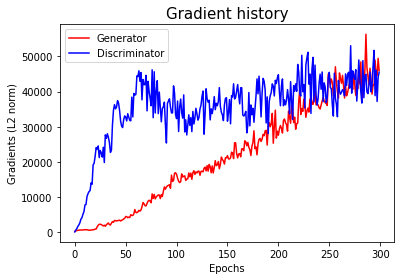

In [17]:
import pickle

# GENERATE, PLOT AND SAVE DATA 
checkpoint_dir = 'model_checkpoints/ckpt-WGANGP-CWT/'
checkpoint_prefix = os.path.join(project_fname, checkpoint_dir)

gen_model_names = ['generator_5eeg_person5_task0_18_57_29_14_03_2020.h5',\
                   'generator_5eeg_person5_task1_20_12_31_14_03_2020.h5',\
                   'generator_5eeg_person5_task2_21_37_51_14_03_2020.h5',\
                   'generator_5eeg_person5_task3_23_03_23_14_03_2020.h5']
disc_model_names = ['discriminator_5eeg_person5_task0_18_57_29_14_03_2020.h5',\
                   'discriminator_5eeg_person5_task1_20_12_31_14_03_2020.h5',\
                   'discriminator_5eeg_person5_task2_21_37_51_14_03_2020.h5',\
                   'discriminator_5eeg_person5_task3_23_03_23_14_03_2020.h5']
history_model_names = ['history_5eeg_person5_task0_18_57_29_14_03_2020',\
                   'history_5eeg_person5_task1_20_12_31_14_03_2020',\
                   'history_5eeg_person5_task2_21_37_51_14_03_2020',\
                   'history_5eeg_person5_task3_23_03_23_14_03_2020']

# for task in range(4): 
task = 3

# create 100 fake data points 
N = 100; 
gen_loaded = tf.keras.models.load_model(os.path.join(checkpoint_prefix, gen_model_names[task]))
disc_loaded = tf.keras.models.load_model(os.path.join(checkpoint_prefix, disc_model_names[task]))
fileid = open(os.path.join(checkpoint_prefix,history_model_names[task]),'rb')
history_loaded = pickle.load(fileid)
noise = tf.random.normal([N, 100])  
gen_imgs = gen_loaded(noise, training=False).numpy()

# save data in .npy, shape=(trials, freq_bins, time_bins, eegs)
fname = os.path.join(checkpoint_prefix, 'X_artificial_task{}_subj5_eegs5.npy'.format(task))
#np.save(fname, gen_imgs)

# real images
subj = 5
subsample =5
X_train_valid_subsample, y_train_valid_subsample, person_train_valid_subsample = subsample_data(X_train_valid_norm,y_train_valid, person_train_valid, sample_every=subsample)
X_train, y_train, person_train = split_data_by_subject(X_train_valid_subsample, y_train_valid_subsample, person_train_valid_subsample)
X_train,y_train, person_train = split_data_by_task(X_train[subj],y_train[subj], person_train[subj])
X_train,y_train,person_train = X_train[task],y_train[task],person_train[task]

# ONLY USE 5 EEG CHANNELS: 0 (Fz), 7 (C3), 9 (Cz), 11 (C4), 19 (Pz)
X_train = X_train[:,(0,7,9,11,19),:,:]

# wavelet transform 
N_trials,N_eeg,N_bins,_ = X_train.shape
fs = 250
freq_bins = 50
X_train_cwt = morlet_wavelet_transform(X_train,fs=fs,freq_range=(1,20),freq_bins=freq_bins,w=6)
# reshape for DCGAN 
X_train_cwt = np.swapaxes(np.swapaxes(X_train_cwt,1,3),1,2)
# scale between -1 and 1 for output of Generator
X_train_cwt_norm = 2 * (X_train_cwt - np.min(X_train_cwt,axis=0) ) / (np.max(X_train_cwt,axis=0) - np.min(X_train_cwt,axis=0)) - 1

# plot and save fig fake data example for each EEG
fig, ax = plt.subplots(2,5)
for eeg in range(5): 
    # plotting real data
  img = ax[0][eeg].imshow(X_train_cwt_norm[10, :, :, eeg], vmin=-1, vmax=1, aspect='auto')
  ax[0][eeg].set_title('EEG Channel {}'.format(eeg+1))
  ax[0][eeg].set_xticks([0,100,199])
  ax[0][eeg].set_xticklabels(['0', '2', '4'])
  ax[0][eeg].set_yticks([0,25,49])
  ax[0][eeg].set_yticklabels(['1', '10','20'])
  # plotting fake data
  img = ax[1][eeg].imshow(gen_imgs[2, :, :, eeg], vmin=-1, vmax=1, aspect='auto')
  ax[1][eeg].set_xticks([0,100,199])
  ax[1][eeg].set_xticklabels(['0', '2', '4'])
  ax[1][eeg].set_yticks([0,25,49])
  ax[1][eeg].set_yticklabels(['1', '10','20'])
  if eeg==0: 
    ax[0][eeg].set_ylabel('Frequency (Hz)')
    ax[1][eeg].set_ylabel('Frequency (Hz)')
  elif eeg==2: 
    ax[0][eeg].set_xlabel('Time (s)')
    ax[1][eeg].set_xlabel('Time (s)')
  
fig.subplots_adjust(top=1.0, right=3.0)
cbar_ax = fig.add_axes([3.05, 0.2, 0.05, 0.7])
fig.colorbar(img, cax=cbar_ax)
#fig.suptitle('Generated Data Examples', x=1.55, y=1.05, fontsize=16)
plt.show()
fname = os.path.join(checkpoint_prefix, 'genImgs_task{}_subj5_eegs5.png'.format(task))
#fig.savefig(fname, bbox_inches = 'tight')

# plot and save loss and gradient history 
gen_grads_history, disc_grads_history = history_loaded['grads']['gen'], history_loaded['grads']['disc']
gen_loss_history, disc_loss_history = history_loaded['loss']['gen'], history_loaded['loss']['disc']  

plt.figure()
plt.plot(gen_loss_history, 'r')
plt.plot(disc_loss_history, 'b')
plt.title('Loss history',fontsize=15)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Generator', 'Discriminator'])
plt.show()
fname = os.path.join(checkpoint_prefix, 'lossHistory_task{}_subj5_eegs5.png'.format(task))
#plt.savefig(fname, bbox_inches = 'tight')

plt.figure()
plt.plot(gen_grads_history, 'r')
plt.plot(disc_grads_history, 'b')
plt.title('Gradient history',fontsize=15)
plt.xlabel('Epochs')
plt.ylabel('Gradients (L2 norm)')
plt.legend(['Generator', 'Discriminator'])
plt.show()
fname = os.path.join(checkpoint_prefix, 'gradHistory_task{}_subj5_eegs5.png'.format(task))
#plt.savefig(fname, bbox_inches = 'tight')


In [18]:
generator.summary()
discriminator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 22528)             2252800   
_________________________________________________________________
batch_normalization (BatchNo (None, 22528)             90112     
_________________________________________________________________
re_lu (ReLU)                 (None, 22528)             0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 11, 512)        0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 11, 24, 256)       2621440   
_________________________________________________________________
batch_normalization_1 (Batch (None, 11, 24, 256)       1024      
_________________________________________________________________
re_lu_1 (ReLU)               (None, 11, 24, 256)       0

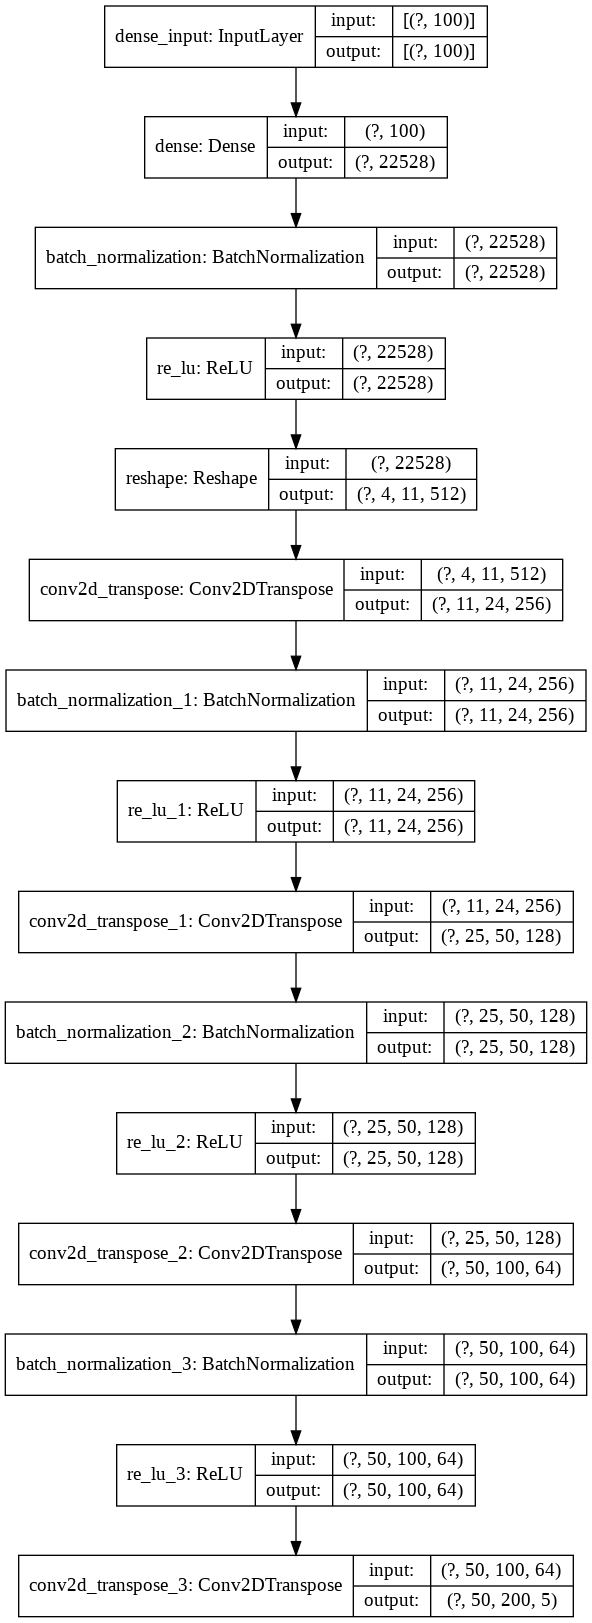

In [21]:
from tensorflow.keras.utils import plot_model

plot_model(wgan.generator, show_shapes=True, expand_nested=True)

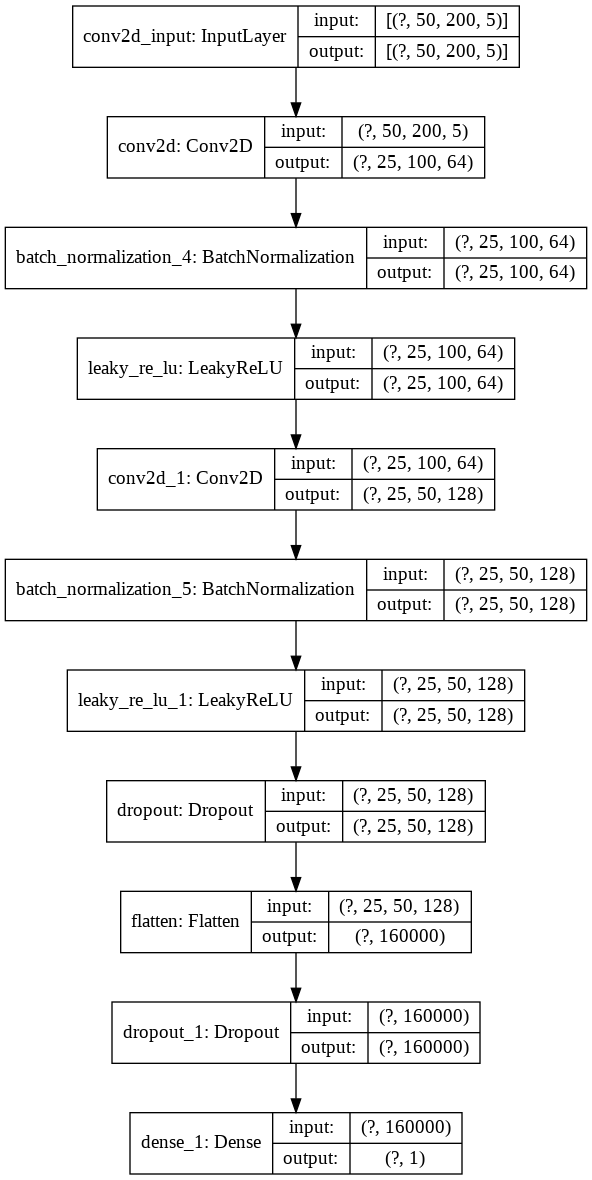

In [22]:
plot_model(wgan.discriminator, show_shapes=True, expand_nested=True)